In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split, KFold, cross_val_predict
from sklearn.metrics import mean_squared_error,r2_score,roc_curve,auc,precision_recall_curve, accuracy_score, \
recall_score, precision_score, confusion_matrix, mean_absolute_error, f1_score, cohen_kappa_score, matthews_corrcoef
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor,GradientBoostingClassifier,BaggingRegressor,BaggingClassifier, \
AdaBoostRegressor,AdaBoostClassifier,RandomForestRegressor,RandomForestClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from pyearth import Earth
import itertools as it
import time as time
import xgboost as xgb
import re 


from imblearn.over_sampling import SMOTE
from collections import Counter
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder

In [2]:
X_train = pd.read_csv('X_train_stratified.csv')
y_train = pd.read_csv('y_train_stratified.csv')
X_test = pd.read_csv('X_test_stratified.csv')
y_test = pd.read_csv('y_test_stratified.csv')

In [89]:
y_train.describe()

,quality
count,3918.000000
mean,5.877999
std,0.885547
min,3.000000
25%,5.000000
50%,6.000000
75%,6.000000
max,9.000000


In [90]:
y_test.describe()

,quality
count,980.000000
mean,5.877551
std,0.886458
min,3.000000
25%,5.000000
50%,6.000000
75%,6.000000
max,9.000000


In [ ]:
# Histogram for quality
plt.hist(df['quality'], bins=10)
plt.title('Histogram of Quality Ratings')
plt.xlabel('Quality Rating')
plt.ylabel('Frequency')
plt.show()

In [3]:
#Defining the object to build a regression tree
model = DecisionTreeClassifier(random_state=1) 

#Fitting the regression tree to the data
model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

In [4]:
# Maximum number of leaves
model.get_n_leaves()

1037

In [5]:
# Maximum depth
model.get_depth()

25

In [27]:
len(X_train.columns)

11

In [31]:
model = DecisionTreeRegressor(random_state=1, max_depth = 6, max_features = 11, 
                              max_leaf_nodes= 102, min_samples_leaf = 9)
model.fit(X_train, y_train)
pred = model.predict(X_test)
np.sqrt(mean_squared_error(pred, y_test))

0.7322219445628427

In [3]:
#Defining the object to build a regression tree
model = DecisionTreeClassifier(random_state=1) 

#Fitting the regression tree to the data
model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

In [42]:
# coarse grid search
param_grid = {    
    'max_depth': range(2,26,2),
    'max_leaf_nodes': range(2,1038,100),
    'max_features': range(1, 12,2),
    'min_samples_leaf': range(1,10,2),
    'min_samples_split': range(2,10)
}


#Grid search to optimize parameter values
skf = StratifiedKFold(n_splits=2)#The folds are made by preserving the percentage of samples for each class.

#Minimizing FNR is equivalent to maximizing recall
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, scoring=['f1_weighted','accuracy'], refit= 'f1_weighted', cv=skf, n_jobs=-1, verbose = True)
grid_search.fit(X_train, y_train)

# make the predictions
y_pred = grid_search.predict(X_test)

print('Train F1-score : %.3f'%grid_search.best_estimator_.score(X_train, y_train))
print('Test F1-score : %.3f'%grid_search.best_estimator_.score(X_test, y_test))
print('Best F1-score Through Grid Search : %.3f'%grid_search.best_score_)

print('Best params for F1-score')
print(grid_search.best_params_)

Fitting 2 folds for each of 31680 candidates, totalling 63360 fits
Train accuracy : 0.846
Test accuracy : 0.535
Best Accuracy Through Grid Search : 0.540
Best params for recall
{'max_depth': 16, 'max_features': 3, 'max_leaf_nodes': 602, 'min_samples_leaf': 1, 'min_samples_split': 2}


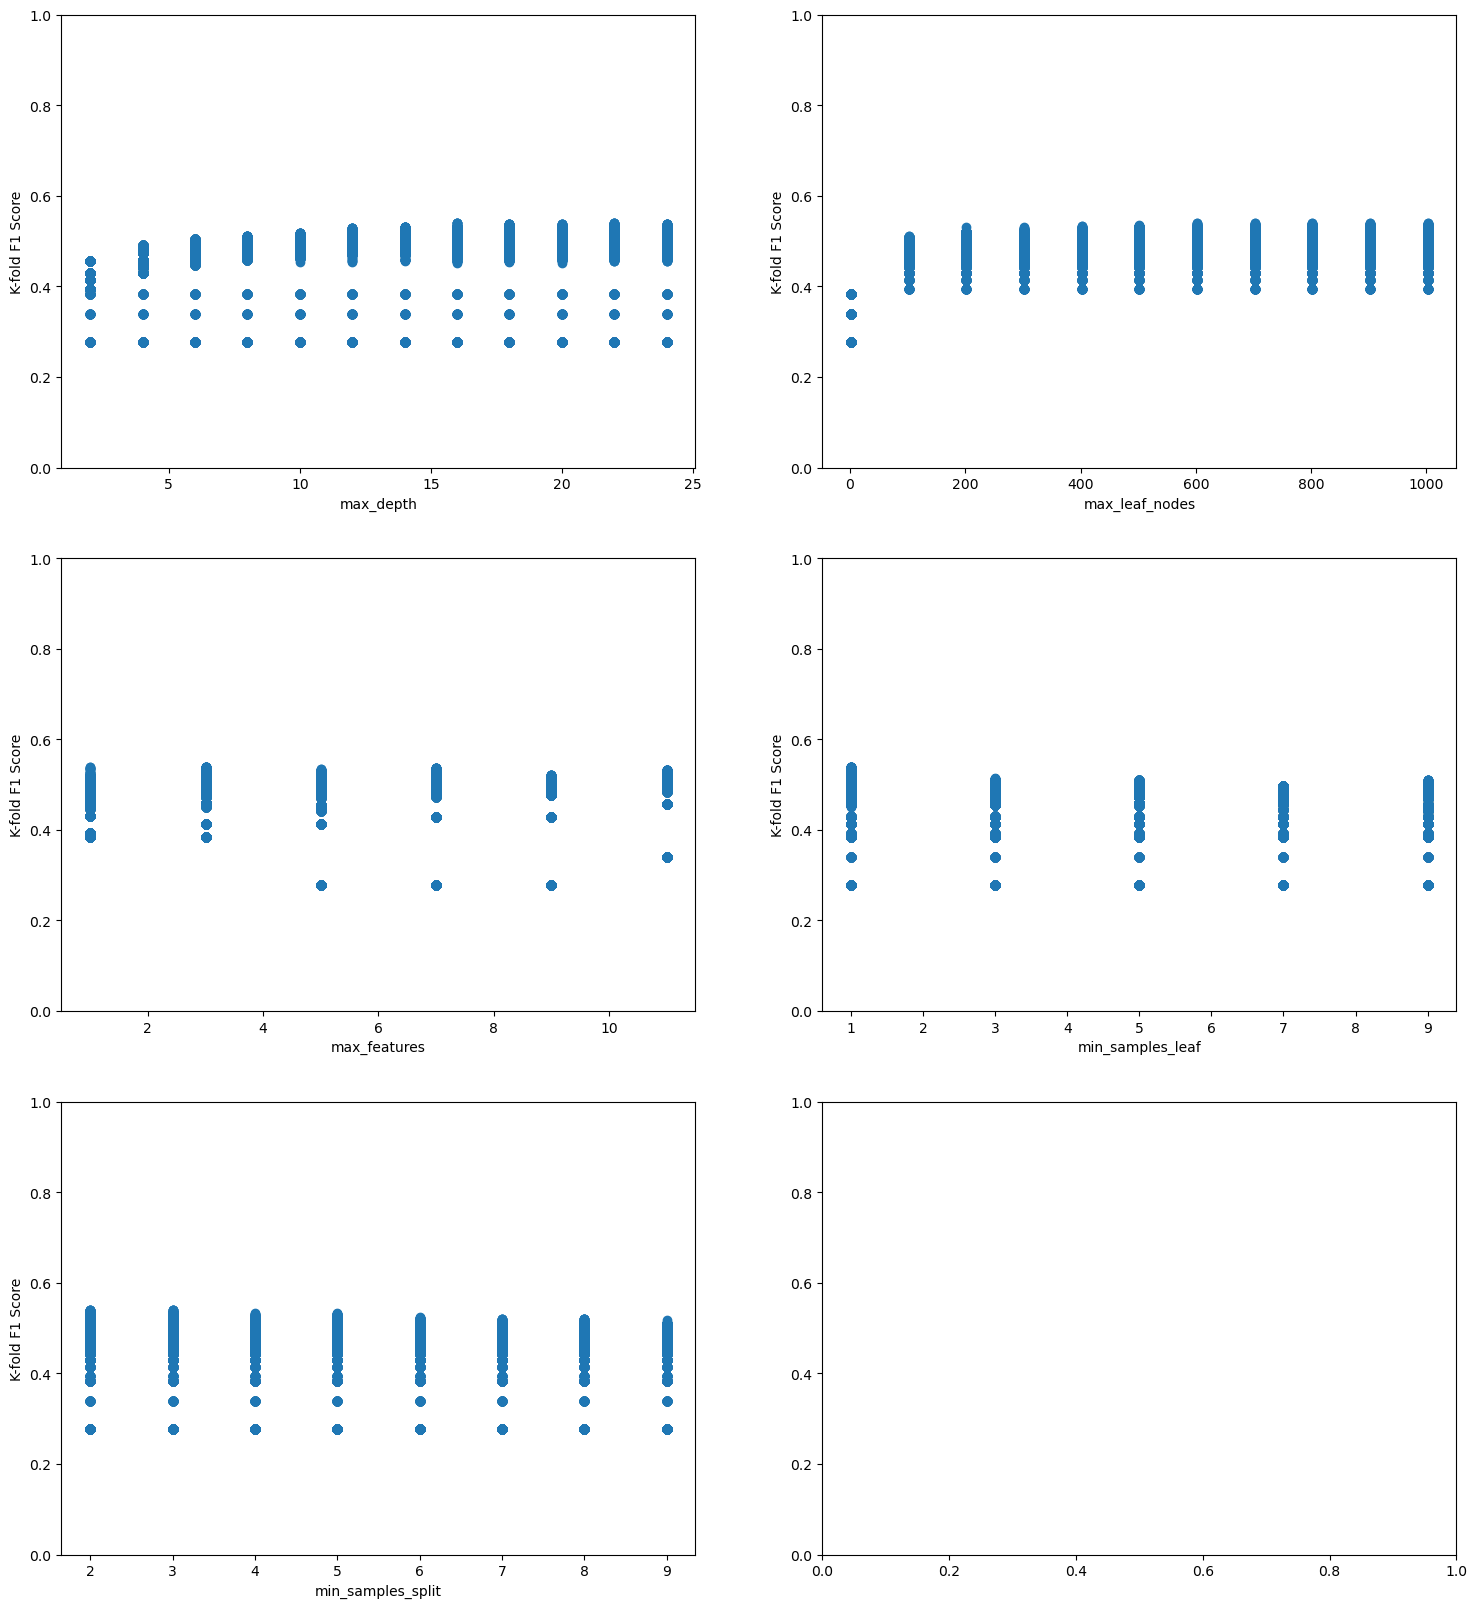

In [46]:
cv_results = pd.DataFrame(grid_search.cv_results_)
fig, axes = plt.subplots(3,2,figsize=(18,20))
plt.subplots_adjust(wspace=0.2)
axes[0,0].plot(cv_results.param_max_depth, cv_results.mean_test_f1_weighted, 'o')
axes[0,0].set_ylim([0,1])
axes[0,0].set_xlabel('max_depth')
axes[0,0].set_ylabel('K-fold F1 Score')
axes[0,1].plot(cv_results.param_max_leaf_nodes, cv_results.mean_test_f1_weighted, 'o')
axes[0,1].set_ylim([0,1])
axes[0,1].set_xlabel('max_leaf_nodes')
axes[0,1].set_ylabel('K-fold F1 Score')
axes[1,0].plot(cv_results.param_max_features, cv_results.mean_test_f1_weighted, 'o')
axes[1,0].set_ylim([0,1])
axes[1,0].set_xlabel('max_features')
axes[1,0].set_ylabel('K-fold F1 Score')
axes[1,1].plot(cv_results.param_min_samples_leaf, cv_results.mean_test_f1_weighted, 'o')
axes[1,1].set_ylim([0,1])
axes[1,1].set_xlabel('min_samples_leaf')
axes[1,1].set_ylabel('K-fold F1 Score')
axes[2,0].plot(cv_results.param_min_samples_split, cv_results.mean_test_f1_weighted, 'o')
axes[2,0].set_ylim([0,1])
axes[2,0].set_xlabel('min_samples_split')
axes[2,0].set_ylabel('K-fold F1 Score');

In [20]:
# coarse grid search
param_grid = {    
    'max_depth': range(6,26),
    'max_leaf_nodes': range(100,1038,50),
    'max_features': range(1, 12)
}


#Grid search to optimize parameter values
skf = StratifiedKFold(n_splits=2)#The folds are made by preserving the percentage of samples for each class.

#Minimizing FNR is equivalent to maximizing recall
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, scoring=['f1_weighted','accuracy'], refit= 'f1_weighted', cv=skf, n_jobs=-1, verbose = True)
grid_search.fit(X_train, y_train)

# make the predictions
y_pred = grid_search.predict(X_test)

print('Train accuracy : %.3f'%grid_search.best_estimator_.score(X_train, y_train))
print('Test accuracy : %.3f'%grid_search.best_estimator_.score(X_test, y_test))
print('Best Accuracy Through Grid Search : %.3f'%grid_search.best_score_)

print('Best params for recall')
print(grid_search.best_params_)

Fitting 2 folds for each of 37620 candidates, totalling 75240 fits
Train accuracy : 0.876
Test accuracy : 0.562
Best Accuracy Through Grid Search : 0.542
Best params for recall
{'max_depth': 17, 'max_features': 4, 'max_leaf_nodes': 650, 'min_samples_leaf': 1}


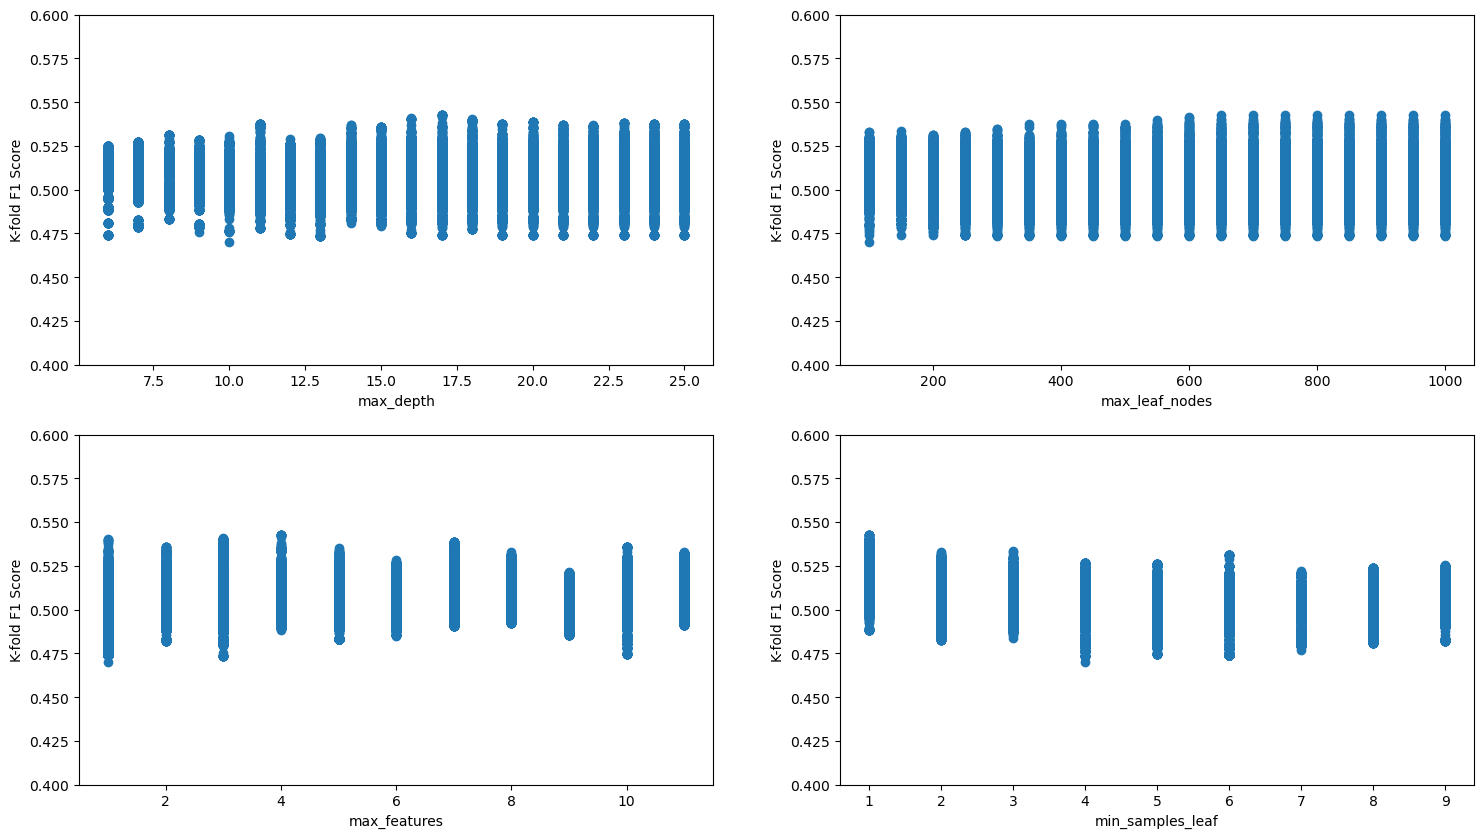

In [21]:
cv_results = pd.DataFrame(grid_search.cv_results_)
fig, axes = plt.subplots(2,2,figsize=(18,10))
plt.subplots_adjust(wspace=0.2)
axes[0,0].plot(cv_results.param_max_depth, cv_results.mean_test_accuracy, 'o')
axes[0,0].set_ylim([0.4, 0.6])
axes[0,0].set_xlabel('max_depth')
axes[0,0].set_ylabel('K-fold F1 Score')
axes[0,1].plot(cv_results.param_max_leaf_nodes, cv_results.mean_test_accuracy, 'o')
axes[0,1].set_ylim([0.4, 0.6])
axes[0,1].set_xlabel('max_leaf_nodes')
axes[0,1].set_ylabel('K-fold F1 Score')
axes[1,0].plot(cv_results.param_max_features, cv_results.mean_test_accuracy, 'o')
axes[1,0].set_ylim([0.4, 0.6])
axes[1,0].set_xlabel('max_features')
axes[1,0].set_ylabel('K-fold F1 Score')
axes[1,1].plot(cv_results.param_min_samples_leaf, cv_results.mean_test_accuracy, 'o')
axes[1,1].set_ylim([0.4, 0.6])
axes[1,1].set_xlabel('min_samples_leaf')
axes[1,1].set_ylabel('K-fold F1 Score');

In [24]:
# finer grid search
param_grid = {    
    'max_depth': range(11,26),
    'max_leaf_nodes': range(500,1038,50),
    'max_features': range(1,8)
}


#Grid search to optimize parameter values
skf = StratifiedKFold(n_splits=2)#The folds are made by preserving the percentage of samples for each class.

#Minimizing FNR is equivalent to maximizing recall
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, scoring=['f1_weighted','accuracy'], refit= 'f1_weighted', cv=skf, n_jobs=-1, verbose = True)
grid_search.fit(X_train, y_train)

# make the predictions
y_pred = grid_search.predict(X_test)

print('Train accuracy : %.3f'%grid_search.best_estimator_.score(X_train, y_train))
print('Test accuracy : %.3f'%grid_search.best_estimator_.score(X_test, y_test))
print('Best Accuracy Through Grid Search : %.3f'%grid_search.best_score_)

print('Best params for recall')
print(grid_search.best_params_)

Fitting 2 folds for each of 1155 candidates, totalling 2310 fits
Train accuracy : 0.876
Test accuracy : 0.562
Best Accuracy Through Grid Search : 0.542
Best params for recall
{'max_depth': 17, 'max_features': 4, 'max_leaf_nodes': 650}


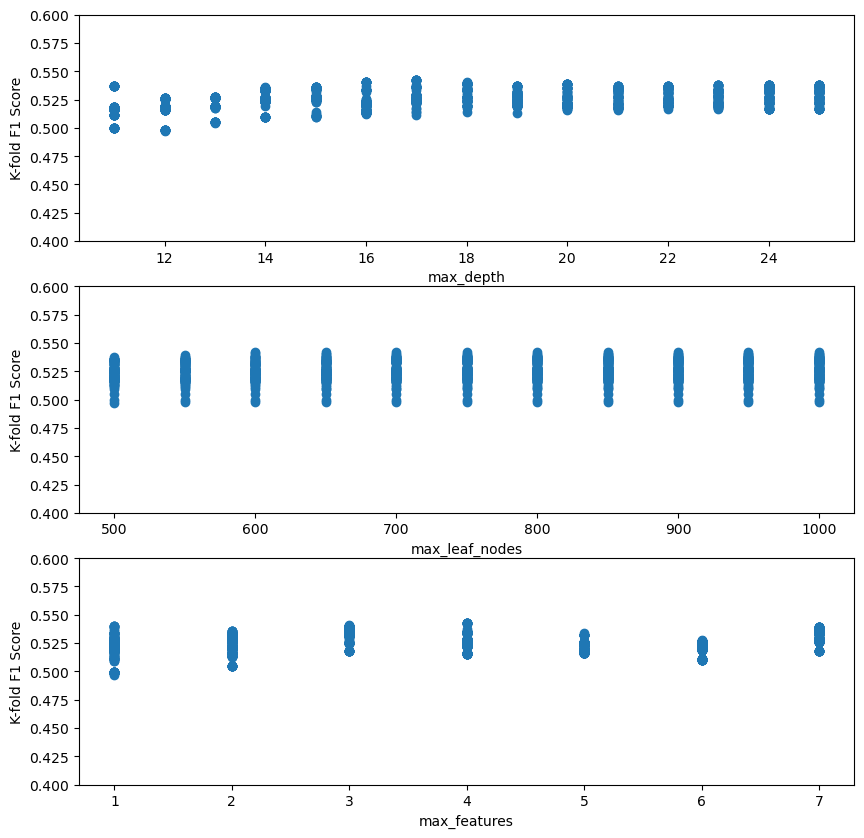

In [25]:
cv_results = pd.DataFrame(grid_search.cv_results_)
fig, axes = plt.subplots(3,1,figsize=(10,10))
plt.subplots_adjust(wspace=0.2)
axes[0].plot(cv_results.param_max_depth, cv_results.mean_test_accuracy, 'o')
axes[0].set_ylim([0.4, 0.6])
axes[0].set_xlabel('max_depth')
axes[0].set_ylabel('K-fold F1 Score')
axes[1].plot(cv_results.param_max_leaf_nodes, cv_results.mean_test_accuracy, 'o')
axes[1].set_ylim([0.4, 0.6])
axes[1].set_xlabel('max_leaf_nodes')
axes[1].set_ylabel('K-fold F1 Score')
axes[2].plot(cv_results.param_max_features, cv_results.mean_test_accuracy, 'o')
axes[2].set_ylim([0.4, 0.6])
axes[2].set_xlabel('max_features')
axes[2].set_ylabel('K-fold F1 Score');

In [26]:
# finer grid search
param_grid = {    
    'max_depth': range(11,26),
    'max_leaf_nodes': range(500,1038),
    'max_features': range(1,8)
}


#Grid search to optimize parameter values
skf = StratifiedKFold(n_splits=2)#The folds are made by preserving the percentage of samples for each class.

#Minimizing FNR is equivalent to maximizing recall
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, scoring=['f1_weighted','accuracy'], refit= 'f1_weighted', cv=skf, n_jobs=-1, verbose = True)
grid_search.fit(X_train, y_train)

# make the predictions
y_pred = grid_search.predict(X_test)

print('Train accuracy : %.3f'%grid_search.best_estimator_.score(X_train, y_train))
print('Test accuracy : %.3f'%grid_search.best_estimator_.score(X_test, y_test))
print('Best Accuracy Through Grid Search : %.3f'%grid_search.best_score_)

print('Best params for recall')
print(grid_search.best_params_)

Fitting 2 folds for each of 56490 candidates, totalling 112980 fits
Train accuracy : 0.864
Test accuracy : 0.557
Best Accuracy Through Grid Search : 0.542
Best params for recall
{'max_depth': 17, 'max_features': 4, 'max_leaf_nodes': 613}


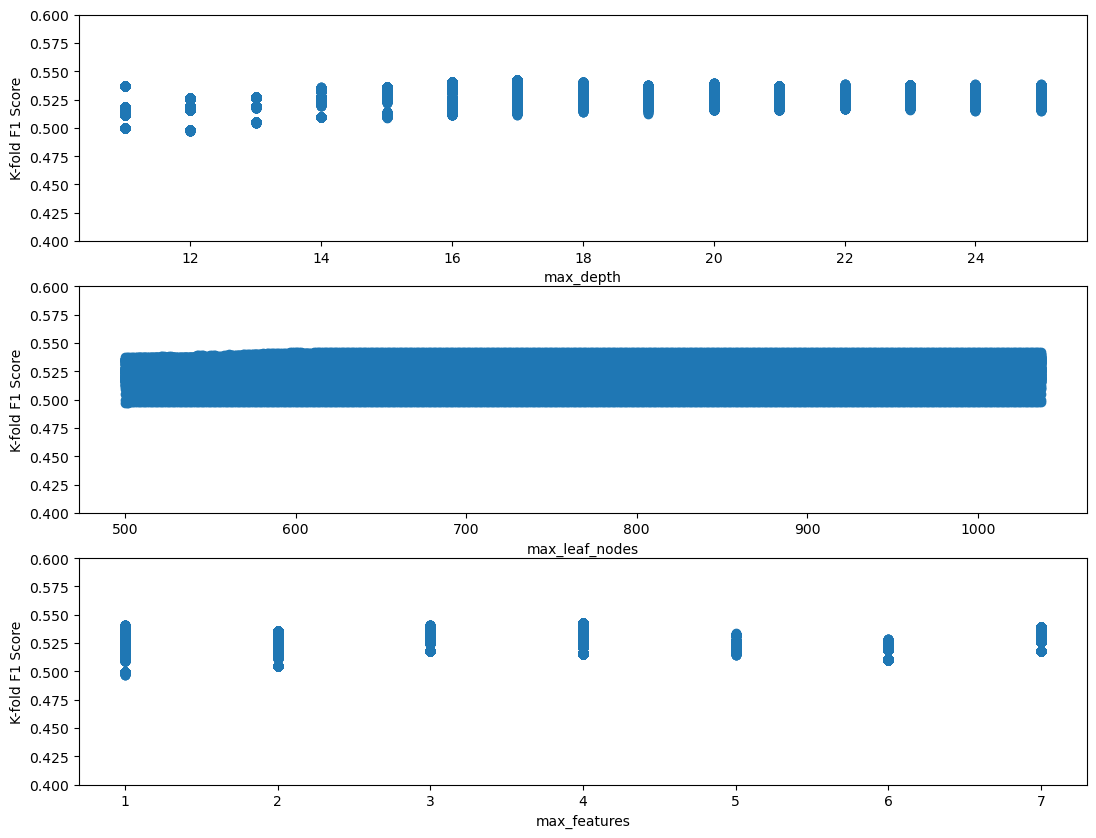

In [37]:
cv_results = pd.DataFrame(grid_search.cv_results_)
fig, axes = plt.subplots(3,1,figsize=(13,10))
plt.subplots_adjust(wspace=0.2)
axes[0].plot(cv_results.param_max_depth, cv_results.mean_test_accuracy, 'o')
axes[0].set_ylim([0.4, 0.6])
axes[0].set_xlabel('max_depth')
axes[0].set_ylabel('K-fold F1 Score')
axes[1].plot(cv_results.param_max_leaf_nodes, cv_results.mean_test_accuracy, 'o')
axes[1].set_ylim([0.4, 0.6])
axes[1].set_xlabel('max_leaf_nodes')
axes[1].set_ylabel('K-fold F1 Score')
axes[2].plot(cv_results.param_max_features, cv_results.mean_test_accuracy, 'o')
axes[2].set_ylim([0.4, 0.6])
axes[2].set_xlabel('max_features')
axes[2].set_ylabel('K-fold F1 Score');

In [61]:
#Defining the object to build a classification tree
model = DecisionTreeClassifier(random_state=1, max_depth=17, max_features = 4, max_leaf_nodes=613)
#model = DecisionTreeClassifier(random_state=1)
#Fitting the regression tree to the data
model.fit(X_train, y_train)

y_pred = model.predict(X_test)



In [62]:
#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_test))  

#Computing the precision and recall
print("F1 Weighted: ", f1_score(y_test, y_pred, average='weighted'))
print("Kappa Score: ", cohen_kappa_score(y_test, y_pred)) # Humble moderate
print("Matthew Correlation: ", matthews_corrcoef(y_test, y_pred)) #moderately strong correlation


#print("Recall: ", recall_score(y_test, y_pred))

#Confusion matrix
#cm = pd.DataFrame(confusion_matrix(y_test, y_pred), 
           #       columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
#sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

Accuracy:  0.5571428571428572
F1 Weighted:  0.5548839304326718
Kappa Score:  0.33807382783258555
Matthew Correlation:  0.3382095055071843


In [63]:
y_pred = grid_search.predict(X_train)
#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_train))  

#Computing the precision and recall
print("F1 Weighted: ", f1_score(y_train, y_pred, average = 'weighted'))

Accuracy:  0.8458397141398672
F1 Weighted:  0.8446781362131206


In [86]:
#Defining the object to build a classification tree
#model = DecisionTreeClassifier(random_state=1, max_depth=17, max_features = 4, max_leaf_nodes=613)
model = DecisionTreeClassifier(random_state=1)
#Fitting the regression tree to the data
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [87]:
#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_test))  

#Computing the precision and recall
print("F1 Weighted: ", f1_score(y_test, y_pred, average='weighted'))

Accuracy:  0.5867346938775511
F1 Weighted:  0.5872516277970115


In [88]:
y_pred = grid_search.predict(X_train)
#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_train))  

#Computing the precision and recall
print("F1 Weighted: ", f1_score(y_train, y_pred, average = 'weighted'))

Accuracy:  0.8458397141398672
F1 Weighted:  0.8446781362131206


In [10]:
model = DecisionTreeClassifier(random_state = 1)#model without any restrictions
path= model.cost_complexity_pruning_path(X_train,y_train)# Compute the pruning path during Minimal Cost-Complexity Pruning.

In [11]:
alphas=path['ccp_alphas']
len(alphas)

637

In [13]:
#Grid search to optimize parameter values

skf = StratifiedKFold(n_splits=2)
grid_search = GridSearchCV(DecisionTreeClassifier(random_state = 1), param_grid = {'ccp_alpha':alphas}, 
                                                  scoring=['f1_weighted','accuracy'], 
                                                  refit="f1_weighted", cv=skf, n_jobs=-1, verbose = True)
grid_search.fit(X_train, y_train)

# make the predictions
y_pred = grid_search.predict(X_test)

print('Best params for recall')
print(grid_search.best_params_)

Fitting 2 folds for each of 637 candidates, totalling 1274 fits
Best params for recall
{'ccp_alpha': 0.0004770202953653348}


In [14]:
# Model with the optimal value of 'ccp_alpha'
model = DecisionTreeClassifier(ccp_alpha=0.0004770202953653348,random_state=1)
model.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0004770202953653348, random_state=1)

In [15]:
y_pred = model.predict(X_test)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_test))  

#Computing the precision and recall
print("F1 Weighted: ", f1_score(y_test, y_pred, average = 'weighted'))
print("Kappa Score: ", cohen_kappa_score(y_test, y_pred)) # Humble moderate
print("Matthew Correlation: ", matthews_corrcoef(y_test, y_pred)) #moderately strong correlation

Accuracy:  0.5683673469387756
F1 Weighted:  0.5666844381852645
Kappa Score:  0.3581700398840637
Matthew Correlation:  0.3582294731162765


In [17]:
y_pred = grid_search.predict(X_train)
#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_train))  

#Computing the precision and recall
print("F1 Weighted: ", f1_score(y_train, y_pred, average = 'weighted'))

Accuracy:  0.8779989790709546
F1 Weighted:  0.874744405136114
